In [ ]:
import torch

seq_lens_kv = torch.ones(64) * 1000
mask = torch.full((4, 4), 0)
mask_cond = torch.arange(mask.size(-1))
mask.masked_fill_(mask_cond < (mask_cond + 1).view(mask.size(-1), 1), 1)
mask

tensor([[1, 1, 0, 0],
        [1, 1, 0, 0],
        [1, 1, 1, 0],
        [1, 1, 1, 1]])

In [17]:
mask.cumsum(-1)

tensor([[1, 2, 2, 2],
        [1, 2, 2, 2],
        [1, 2, 3, 3],
        [1, 2, 3, 4]])

In [8]:
mask.cumsum(-1)

tensor([[1, 1, 1, 1],
        [1, 2, 2, 2],
        [1, 2, 3, 3],
        [1, 2, 3, 4]])

In [5]:
mask.shape

torch.Size([4, 104])

In [ ]:
import numpy as np

def idct_64_matrix():
    N = 8
    M = np.zeros((N*N, N*N))
    for i in range(N):
        for j in range(N):
            k = i * N + j
            for u in range(N):
                alpha_u = np.sqrt(1/N) if u == 0 else np.sqrt(2/N)
                cos_i_u = np.cos((2*i + 1) * u * np.pi / 16)
                for v in range(N):
                    l = u * N + v
                    alpha_v = np.sqrt(1/N) if v == 0 else np.sqrt(2/N)
                    cos_j_v = np.cos((2*j + 1) * v * np.pi / 16)
                    M[k, l] = (alpha_u * alpha_v * cos_i_u * cos_j_v)**2
    return M

In [2]:
M = idct_64_matrix()

In [23]:
M

array([[ 0.125     ,  0.17337998,  0.16332037, ...,  0.02709659,
         0.01866446,  0.00951506],
       [ 0.125     ,  0.14698445,  0.06764951, ..., -0.04783543,
        -0.04505999, -0.02709659],
       [ 0.125     ,  0.09821187, -0.06764951, ...,  0.00951506,
         0.04505999,  0.04055292],
       ...,
       [ 0.125     , -0.09821187, -0.06764951, ...,  0.00951506,
        -0.04505999,  0.04055292],
       [ 0.125     , -0.14698445,  0.06764951, ..., -0.04783543,
         0.04505999, -0.02709659],
       [ 0.125     , -0.17337998,  0.16332037, ...,  0.02709659,
        -0.01866446,  0.00951506]])

In [15]:
A = M[:,1:]
A[:4,:4]
A.shape

(64, 63)

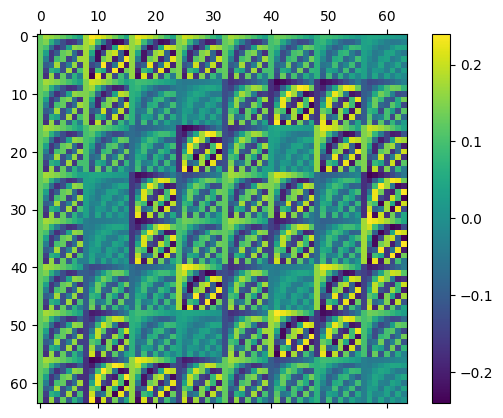

In [4]:
import matplotlib.pyplot as plt
figure = plt.figure()
axes = figure.add_subplot(111)

# using the matshow() function 
caxes = axes.matshow(M, interpolation ='nearest')
figure.colorbar(caxes)

In [ ]:
b = np.ones(A.shape[0])
x = np.linalg.solve(A, b)
x

LinAlgError: Last 2 dimensions of the array must be square

In [18]:
import numpy as np

# 构造 b 为全 1 向量 (64,)
b = np.ones(64)

# 最小二乘解
x, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)

print("解向量 x 的形状:", x.shape)
print("解向量 x =", x)

# 验证 Ax 是否接近 b
print("Ax ≈", A @ x)
print("残差 ||Ax - b||^2 =", np.sum((A @ x - b) ** 2))

解向量 x 的形状: (63,)
解向量 x = [ 2.22044605e-16 -1.28162905e-15  1.58150970e-15  5.13148044e-17
  3.04462354e-15 -5.15329772e-16  8.69678933e-16  1.41168344e-15
  1.19476692e-15  2.17222080e-15 -8.43907749e-16 -2.30036234e-15
 -1.66254513e-16 -6.13764592e-16  1.25550797e-15 -6.66036842e-16
 -3.81195916e-16 -7.35139302e-16  1.68343022e-16  2.73494214e-16
 -5.49705283e-16  1.28023055e-15 -6.15051728e-16  1.60821638e-15
  8.93218024e-17  7.86947783e-16  7.19869789e-17  8.23440135e-16
  5.05947148e-16  4.19416161e-16  7.46638065e-16 -1.75267552e-16
 -2.68567187e-16  4.17029608e-16  2.22281347e-16  8.49386620e-16
 -2.53294654e-16 -5.51133422e-16  9.83298864e-17  3.57900733e-15
 -9.79986852e-16  8.32886768e-16 -5.84395683e-16  1.41585652e-15
 -8.31686980e-16 -6.46856425e-16  1.06093706e-15 -3.18620383e-15
 -6.21842810e-16  6.90647067e-16  2.88644383e-15  3.58127438e-16
  1.62389345e-15 -1.97335075e-15  1.79419942e-16 -2.70583481e-16
  1.79459338e-15 -1.83535163e-16 -6.47952618e-16  1.45614081e-16


/var/folders/78/vmscn0252f30hkbwyc9zv4gw0000gn/T/ipykernel_99981/4039531627.py:13: RuntimeWarning: divide by zero encountered in matmul
  print("Ax ≈", A @ x)
/var/folders/78/vmscn0252f30hkbwyc9zv4gw0000gn/T/ipykernel_99981/4039531627.py:13: RuntimeWarning: overflow encountered in matmul
  print("Ax ≈", A @ x)
/var/folders/78/vmscn0252f30hkbwyc9zv4gw0000gn/T/ipykernel_99981/4039531627.py:13: RuntimeWarning: invalid value encountered in matmul
  print("Ax ≈", A @ x)
/var/folders/78/vmscn0252f30hkbwyc9zv4gw0000gn/T/ipykernel_99981/4039531627.py:14: RuntimeWarning: divide by zero encountered in matmul
  print("残差 ||Ax - b||^2 =", np.sum((A @ x - b) ** 2))
/var/folders/78/vmscn0252f30hkbwyc9zv4gw0000gn/T/ipykernel_99981/4039531627.py:14: RuntimeWarning: overflow encountered in matmul
  print("残差 ||Ax - b||^2 =", np.sum((A @ x - b) ** 2))
/var/folders/78/vmscn0252f30hkbwyc9zv4gw0000gn/T/ipykernel_99981/4039531627.py:14: RuntimeWarning: invalid value encountered in matmul
  print("残差 ||Ax - 

In [20]:
rank

np.int32(63)

In [7]:
U, S, Vt = np.linalg.svd(M)
tol = 1e-10
null_mask = (S <= tol)
null_space = Vt[null_mask].T if np.any(null_mask) else np.zeros((M.shape[1], 0))

In [12]:
import numpy as np
from scipy.linalg import null_space

# 示例矩阵 A（秩不足）
A = M
# 求零空间
ns = null_space(A)

print("零空间基向量:\n", ns)

# 取一个非平凡解（任意一个零空间向量）
if ns.size > 0:
    x_nontrivial = ns[:, 0]  # 取第一列
    print("一个非平凡解 x =", x_nontrivial)
else:
    print("只有平凡解 x=0")

零空间基向量:
 []
只有平凡解 x=0


In [5]:
from PIL import Image

# open JPEG
img = Image.open("/Users/haohan/Library/CloudStorage/Dropbox/macscript/local/bin/deep-learning/Paligemma/images.jpeg")

# get quantization tables
qtables = img.quantization

# print them
for table_id, table in qtables.items():
    print(f"Quantization Table {table_id}:")
    for i in range(0, 64, 8):
        print(table[i:i+8])
    print()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/haohan/Library/CloudStorage/Dropbox/macscript/local/bin/deep-learning/Paligemma/images.jpeg'

In [6]:
import numpy as np

means = np.zeros(64)
stds = np.array(qtables[0])
# stds = np.ones(64) 
samples = np.random.normal(loc=means, scale=stds)
print(samples)

NameError: name 'qtables' is not defined

In [16]:
M @ np.array(samples)

/var/folders/78/vmscn0252f30hkbwyc9zv4gw0000gn/T/ipykernel_7915/2568975723.py:1: RuntimeWarning: divide by zero encountered in matmul
  M @ np.array(samples)
/var/folders/78/vmscn0252f30hkbwyc9zv4gw0000gn/T/ipykernel_7915/2568975723.py:1: RuntimeWarning: overflow encountered in matmul
  M @ np.array(samples)
/var/folders/78/vmscn0252f30hkbwyc9zv4gw0000gn/T/ipykernel_7915/2568975723.py:1: RuntimeWarning: invalid value encountered in matmul
  M @ np.array(samples)


array([  5.13087356, -26.99778258,  29.83251505, -21.15051137,
        -2.62920015, -35.33046201, -53.37053704,  82.33951472,
        34.21824465,  17.39337134, -45.92240975,  25.06865924,
        64.32735612, -69.17338117,  44.4874641 , -33.28304404,
       -33.49439772, -17.47390318,  20.77682046, -28.37131891,
        51.19418193,  58.98508678, -95.87243309,  22.19421261,
        89.19363496, -37.67359537, -44.58198495,  74.04988869,
       -46.46925961, -35.15109228,   1.70818792,  -2.83530653,
       -54.11773931,  -5.07234876, -10.40206237, -29.10296423,
        60.12823607, -67.34526376,  53.17900491,   0.69510205,
        38.45470608, -42.18951655, -10.60575362,  -7.85120501,
         7.39149302,  40.39222633, -12.15367637, -13.77631435,
       -15.85489655,   4.49412618,  60.15334892,  20.45755338,
       -31.82469967,   7.79911089,  22.82634986,  -6.05864063,
       -26.53379618,  25.75656211,   5.88161306,   1.67720352,
        -8.6113312 ,  -8.87296303,  30.57015001, -22.96

In [7]:
from PIL import Image
import numpy as np

BASE_QTABLE_LUMA = np.array([
    16,11,10,16,24,40,51,61,
    12,12,14,19,26,58,60,55,
    14,13,16,24,40,57,69,56,
    14,17,22,29,51,87,80,62,
    18,22,37,56,68,109,103,77,
    24,35,55,64,81,104,113,92,
    49,64,78,87,103,121,120,101,
    72,92,95,98,112,100,103,99,
])

def estimate_qf(filename):
    img = Image.open(filename)
    qtables = img.quantization
    qtable_luma = np.array(qtables[0])  # table 0 = luminance

    best_qf = None
    best_err = float("inf")

    for qf in range(1, 101):  # JPEG quality usually 1..100
        if qf < 50:
            scale = 5000 / qf
        else:
            scale = 200 - 2*qf
        scaled = np.floor((BASE_QTABLE_LUMA * scale + 50) / 100)
        scaled = np.clip(scaled, 1, 255)

        err = np.sum(np.abs(scaled - qtable_luma))
        if err < best_err:
            best_err = err
            best_qf = qf

    return best_qf

print("Estimated QF:", estimate_qf("example.jpg"))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/haohan/Library/CloudStorage/Dropbox/macscript/local/bin/ai/Paligemma/example.jpg'

In [8]:
import numpy as np
import cv2

# Read PNG image (BGR by default in OpenCV)
img_bgr = cv2.imread("png.png")

# Convert BGR to YCrCb
img_ycrcb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YCrCb)

# Split into Y, Cr, Cb channels if needed
Y, Cr, Cb = cv2.split(img_ycrcb)

Y = np.float32(Y)

QY = np.array([
    [16,  11,  10,  16,  24,  40,  51,  61],
    [12,  12,  14,  19,  26,  58,  60,  55],
    [14,  13,  16,  24,  40,  57,  69,  56],
    [14,  17,  22,  29,  51,  87,  80,  62],
    [18,  22,  37,  56,  68, 109, 103,  77],
    [24,  35,  55,  64,  81, 104, 113,  92],
    [49,  64,  78,  87, 103, 121, 120, 101],
    [72,  92,  95,  98, 112, 100, 103,  99],
])

distance_blocks = []

h, w = Y.shape
for i in range(0, h, 8):
    for j in range(0, w, 8):
        block = Y[i:i+8, j:j+8]
        if block.shape[0] != 8 or block.shape[1] != 8:
            continue

        # DCT
        dct_block = cv2.dct(block - 128) # shift for JPEG-style
        # Quantization
        quant_block = np.round(dct_block / QY)
        # Unquantization
        dequant_block = quant_block * QY
        # IDCT
        idct_block = cv2.idct(dequant_block) + 128
        distance_block = block - idct_block
        distance_blocks.append(distance_block)


print("Image shape (BGR):", img_bgr.shape)
print("Image shape (YCrCb):", img_ycrcb.shape)
print("Y channel shape:", Y.shape)

Image shape (BGR): (420, 560, 3)
Image shape (YCrCb): (420, 560, 3)
Y channel shape: (420, 560)


In [11]:
import numpy as np
import cv2
import os


def get_distance():
    root_dir = "/Users/haohan/Downloads/images/photo_tecnick"
    count = 0
    dct_distance_blocks = []
    yuv_distance_blocks = []
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.lower().endswith(".png"):
                print(filename)
                count += 1
                if count == 100:
                    return dct_distance_blocks, yuv_distance_blocks 
                filepath = os.path.join(dirpath, filename)
                # Read PNG image (BGR by default in OpenCV)
                img_bgr = cv2.imread(filepath)

                # Convert BGR to YCrCb
                img_ycrcb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YCrCb)

                # Split into Y, Cr, Cb channels if needed
                Y, Cr, Cb = cv2.split(img_ycrcb)

                Y = np.float32(Y)

                QY = np.array([
                    [16,  11,  10,  16,  24,  40,  51,  61],
                    [12,  12,  14,  19,  26,  58,  60,  55],
                    [14,  13,  16,  24,  40,  57,  69,  56],
                    [14,  17,  22,  29,  51,  87,  80,  62],
                    [18,  22,  37,  56,  68, 109, 103,  77],
                    [24,  35,  55,  64,  81, 104, 113,  92],
                    [49,  64,  78,  87, 103, 121, 120, 101],
                    [72,  92,  95,  98, 112, 100, 103,  99],
                ])

                h, w = Y.shape
                for i in range(0, h, 8):
                    for j in range(0, w, 8):
                        block = Y[i:i+8, j:j+8]
                        if block.shape[0] != 8 or block.shape[1] != 8:
                            continue

                        # DCT
                        dct_block = cv2.dct(block - 128) # shift for JPEG-style
                        # Quantization
                        quant_block = np.round(dct_block / QY)
                        # Unquantization
                        dequant_block = quant_block * QY
                        # IDCT
                        idct_block = cv2.idct(dequant_block) + 128
                        dct_distance_block = dct_block - dequant_block
                        yuv_distance_block = block - idct_block
                        dct_distance_blocks.append(dct_distance_block) 
                        yuv_distance_blocks.append(yuv_distance_block) 
                print("Image shape (BGR):", img_bgr.shape)
                print("Image shape (YCrCb):", img_ycrcb.shape)
                print("Y channel shape:", Y.shape)   


In [12]:
distance_blocks = get_distance()
len(distance_blocks)

RGB_OR_1200x1200_001.png
Image shape (BGR): (1200, 1200, 3)
Image shape (YCrCb): (1200, 1200, 3)
Y channel shape: (1200, 1200)
RGB_OR_1200x1200_015.png
Image shape (BGR): (1200, 1200, 3)
Image shape (YCrCb): (1200, 1200, 3)
Y channel shape: (1200, 1200)
RGB_OR_1200x1200_029.png
Image shape (BGR): (1200, 1200, 3)
Image shape (YCrCb): (1200, 1200, 3)
Y channel shape: (1200, 1200)
RGB_OR_1200x1200_028.png
Image shape (BGR): (1200, 1200, 3)
Image shape (YCrCb): (1200, 1200, 3)
Y channel shape: (1200, 1200)
RGB_OR_1200x1200_014.png
Image shape (BGR): (1200, 1200, 3)
Image shape (YCrCb): (1200, 1200, 3)
Y channel shape: (1200, 1200)
RGB_OR_1200x1200_016.png
Image shape (BGR): (1200, 1200, 3)
Image shape (YCrCb): (1200, 1200, 3)
Y channel shape: (1200, 1200)
RGB_OR_1200x1200_002.png
Image shape (BGR): (1200, 1200, 3)
Image shape (YCrCb): (1200, 1200, 3)
Y channel shape: (1200, 1200)
RGB_OR_1200x1200_003.png
Image shape (BGR): (1200, 1200, 3)
Image shape (YCrCb): (1200, 1200, 3)
Y channel shap

libpng warning: iCCP: known incorrect sRGB profile


Image shape (BGR): (1200, 1200, 3)
Image shape (YCrCb): (1200, 1200, 3)
Y channel shape: (1200, 1200)
RGB_OR_1200x1200_098.png
Image shape (BGR): (1200, 1200, 3)
Image shape (YCrCb): (1200, 1200, 3)
Y channel shape: (1200, 1200)
RGB_OR_1200x1200_099.png
Image shape (BGR): (1200, 1200, 3)
Image shape (YCrCb): (1200, 1200, 3)
Y channel shape: (1200, 1200)
RGB_OR_1200x1200_072.png
Image shape (BGR): (1200, 1200, 3)
Image shape (YCrCb): (1200, 1200, 3)
Y channel shape: (1200, 1200)
RGB_OR_1200x1200_066.png
Image shape (BGR): (1200, 1200, 3)
Image shape (YCrCb): (1200, 1200, 3)
Y channel shape: (1200, 1200)
RGB_OR_1200x1200_043.png
Image shape (BGR): (1200, 1200, 3)
Image shape (YCrCb): (1200, 1200, 3)
Y channel shape: (1200, 1200)
RGB_OR_1200x1200_057.png
Image shape (BGR): (1200, 1200, 3)
Image shape (YCrCb): (1200, 1200, 3)
Y channel shape: (1200, 1200)
RGB_OR_1200x1200_080.png
Image shape (BGR): (1200, 1200, 3)
Image shape (YCrCb): (1200, 1200, 3)
Y channel shape: (1200, 1200)
RGB_OR_12

2

In [70]:
distance_blocks[0]

[array([[ 4.50000000e+00, -2.27559388e-01,  1.34619105e+00,
          1.12018812e+00, -2.49999970e-01,  8.48696083e-02,
         -1.64145324e-02, -2.47371107e-01],
        [-1.07140851e+00,  1.78958142e+00,  3.69803667e-01,
         -8.11058208e-02, -3.49325240e-01, -9.56708416e-02,
         -2.74943590e-01, -1.79193139e-01],
        [-6.92903697e-01,  8.39051127e-01,  1.03553355e-01,
         -3.75996947e-01, -3.66268903e-01, -5.62719166e-01,
          5.24735633e-09,  3.73822182e-01],
        [-1.08489007e-01, -2.30969906e-01, -6.48820698e-01,
         -3.30257326e-01,  9.53667998e-01,  3.97447526e-01,
          1.99775487e-01,  5.41931801e-02],
        [ 2.50016451e-01, -8.39266926e-02,  3.66268933e-01,
          4.10484433e-01,  4.99999970e-01, -3.89339268e-01,
         -4.22311574e-01, -2.18800768e-01],
        [-4.35426325e-01, -4.07746643e-01,  4.33528185e-01,
         -2.06105858e-01, -7.52282917e-01,  1.95970833e-02,
          1.67186707e-01, -2.30969891e-01],
        [ 2.8698

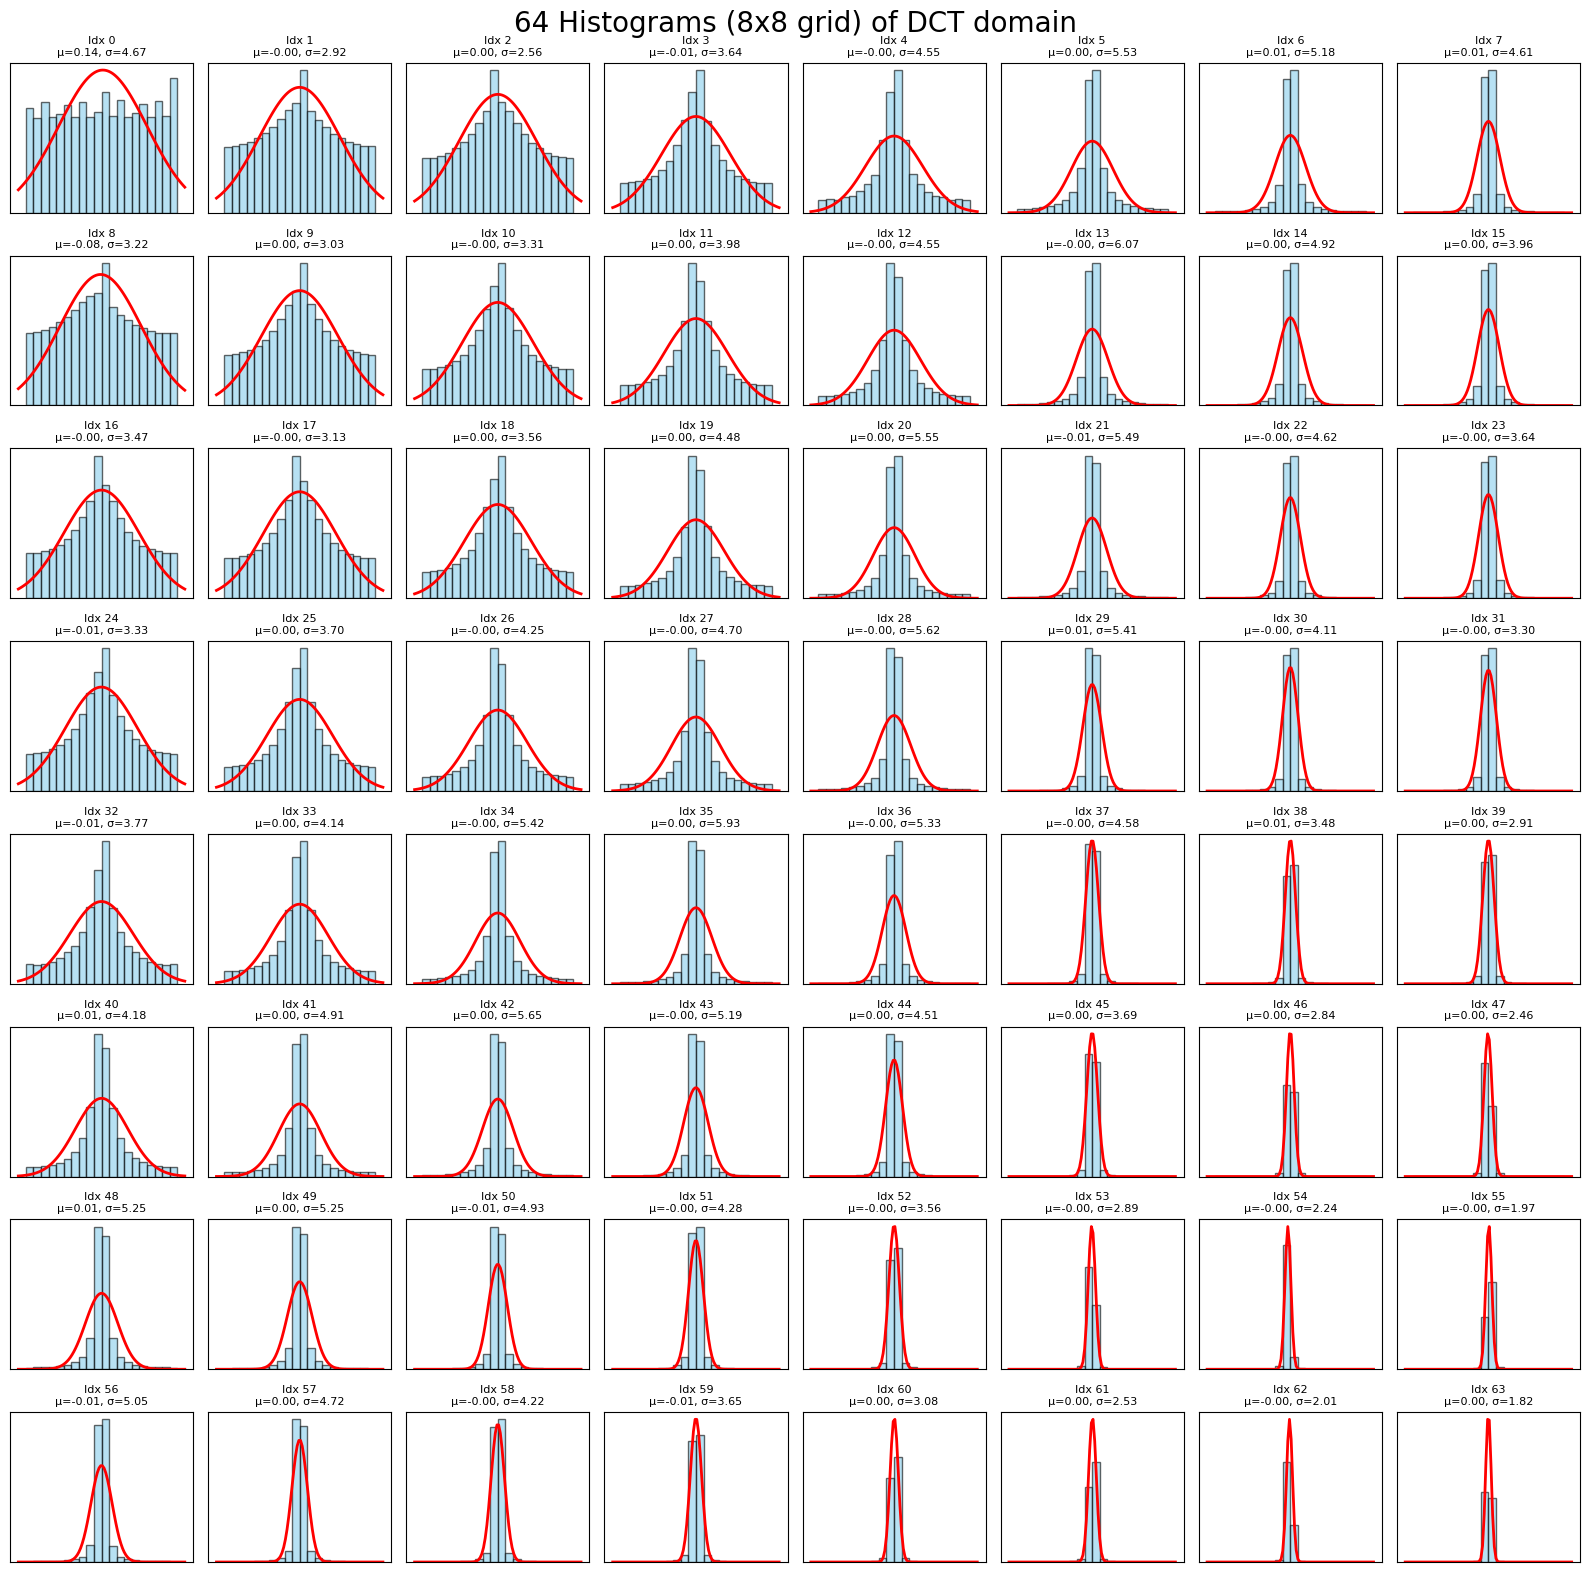

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

values = []
for i in range(8):
    for j in range(8):
        values.append(np.array([distance_blocks[0][k][i][j] for k in range(len(distance_blocks[0]))]))
fig, axes = plt.subplots(8, 8, figsize=(16, 16))
fig.suptitle("64 Histograms (8x8 grid) of DCT domain", fontsize=20)
for idx, ax in enumerate(axes.flat):
    data = values[idx]
    ax.hist(data, bins=20, density=True, alpha=0.6, color="skyblue", edgecolor="black")
    # Overlay Gaussian fit
    mu, std = stats.norm.fit(data)
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    ax.plot(x, p, 'r', linewidth=2)
    ax.set_title(f"Idx {idx}\nμ={mu:.2f}, σ={std:.2f}", fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])


plt.tight_layout()
plt.savefig("dct_histograms.png", dpi=300, bbox_inches="tight")
plt.show()


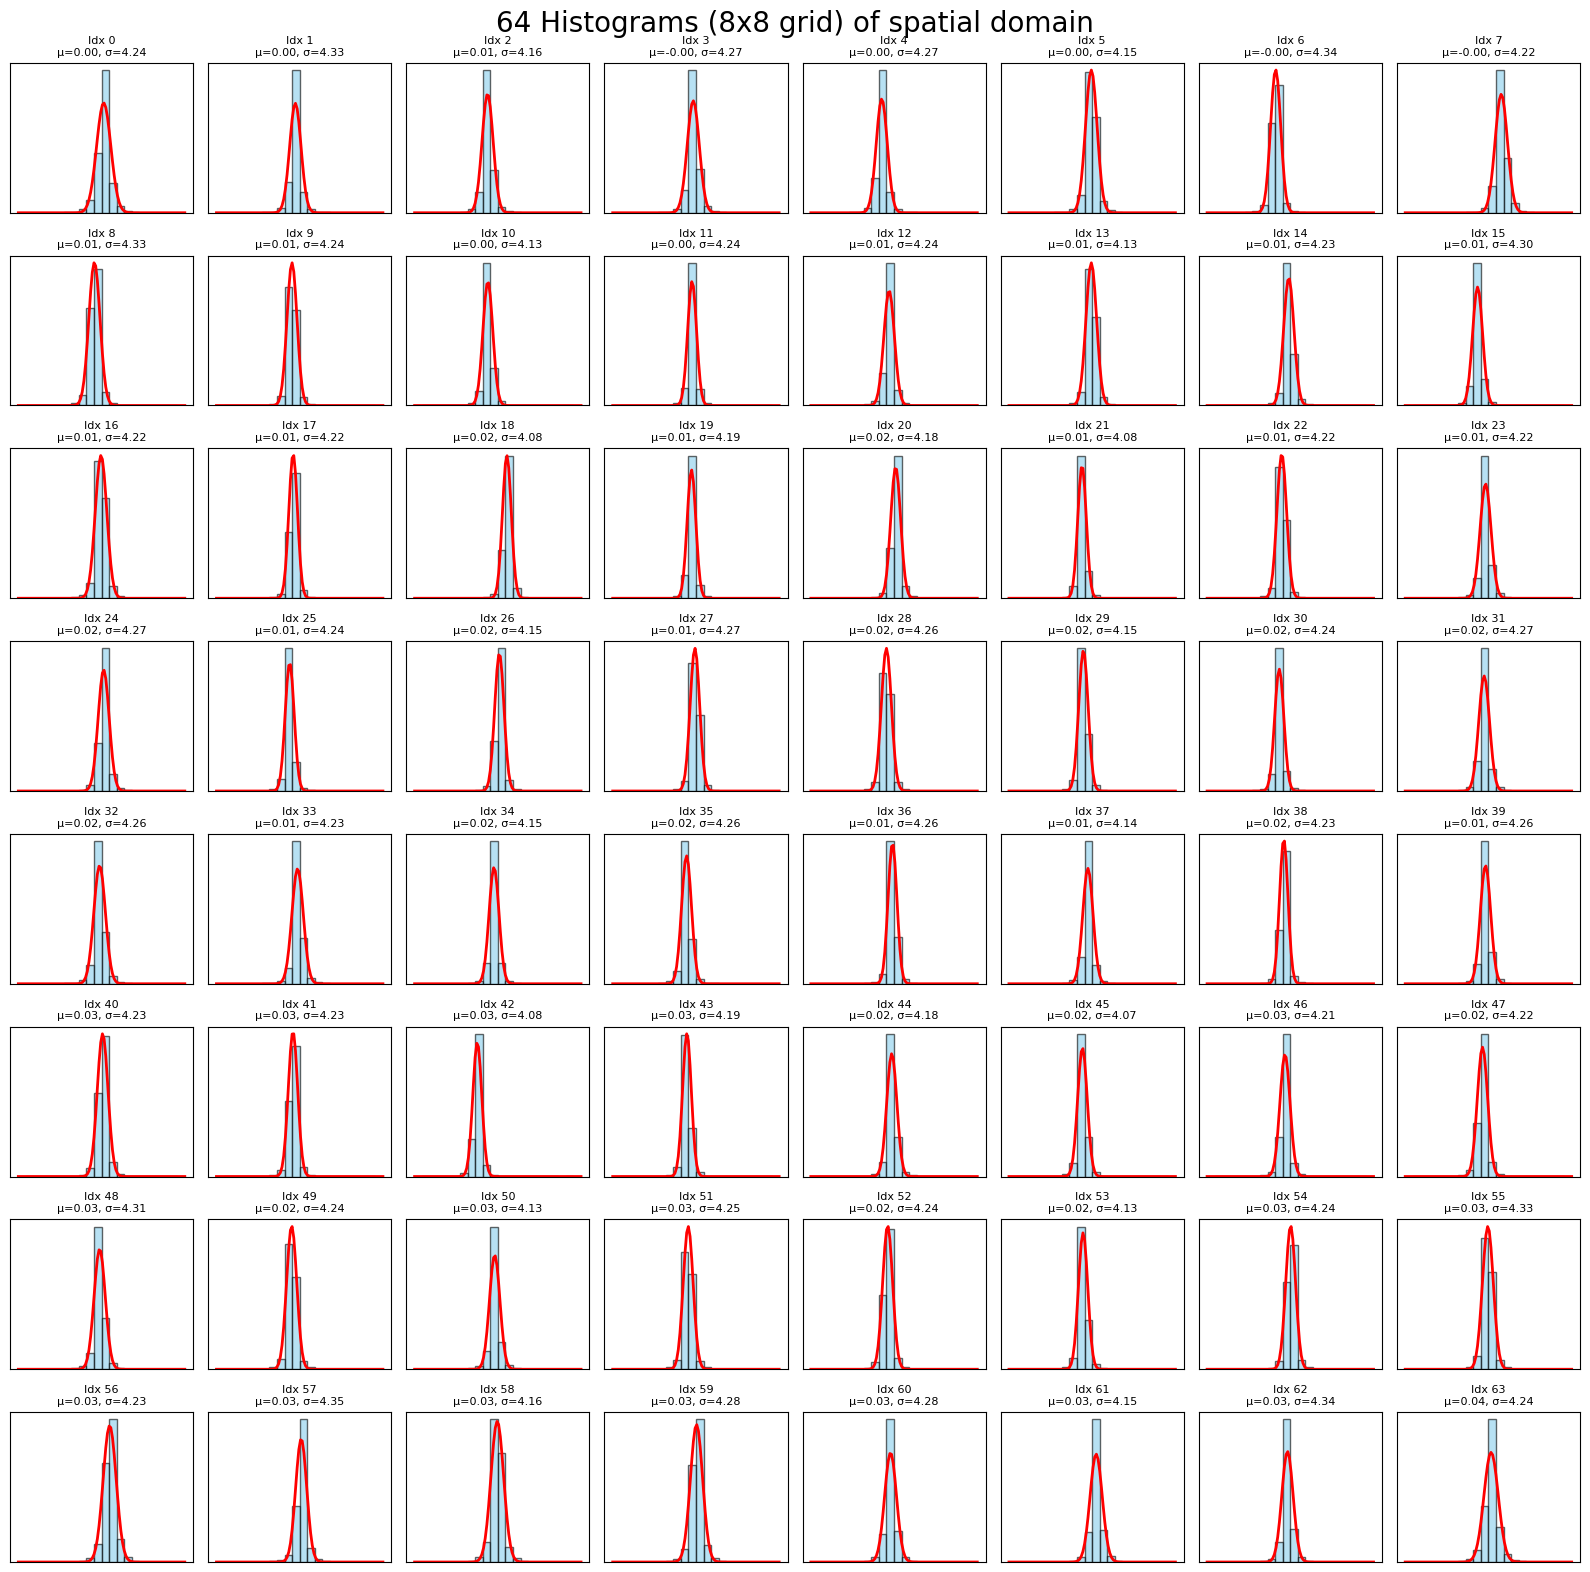

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

values = []
for i in range(8):
    for j in range(8):
        values.append(np.array([distance_blocks[1][k][i][j] for k in range(len(distance_blocks[1]))]))
fig, axes = plt.subplots(8, 8, figsize=(16, 16))
fig.suptitle("64 Histograms (8x8 grid) of spatial domain", fontsize=20)
for idx, ax in enumerate(axes.flat):
    data = values[idx]
    ax.hist(data, bins=20, density=True, alpha=0.6, color="skyblue", edgecolor="black")
    # Overlay Gaussian fit
    mu, std = stats.norm.fit(data)
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    ax.plot(x, p, 'r', linewidth=2)
    ax.set_title(f"Idx {idx}\nμ={mu:.2f}, σ={std:.2f}", fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.savefig("idct_histograms.png", dpi=300, bbox_inches="tight")
plt.show()

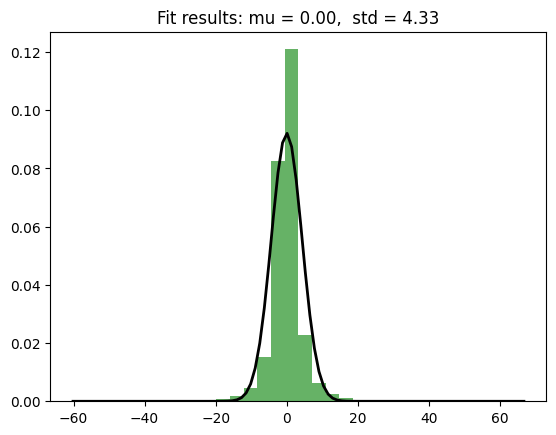

Shapiro-Wilk test: stat=0.876, p=0.000
Kolmogorov-Smirnov test: stat=0.116, p=0.000


/opt/homebrew/Caskroom/miniconda/base/envs/cereal/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 2227500.
  res = hypotest_fun_out(*samples, **kwds)


In [78]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Generate some sample data (Normal with mean=0, std=1)
# data = np.random.normal(0, 1, 500)
data = np.array([distance_blocks[1][i][0][1] for i in range(len(distance_blocks[1]))])

# --- Visual check ---
plt.hist(data, bins=30, density=True, alpha=0.6, color='g')

# Overlay Gaussian fit
mu, std = stats.norm.fit(data)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.title(f"Fit results: mu = {mu:.2f},  std = {std:.2f}")
plt.show()

# --- Statistical tests ---
# Shapiro-Wilk test (for normality)
stat, p_value = stats.shapiro(data)
print("Shapiro-Wilk test: stat=%.3f, p=%.3f" % (stat, p_value))

# Kolmogorov-Smirnov test (compare to N(0,1))
stat, p_value = stats.kstest(data, 'norm', args=(mu, std))
print("Kolmogorov-Smirnov test: stat=%.3f, p=%.3f" % (stat, p_value))

In [54]:
len(distance_blocks)

360360

In [49]:
values = [np.random.randn(100) for _ in range(64)]

In [51]:
len(values)

64

In [1]:
import torch

x = torch.arange(10)   # tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Take every second element: [1, 3, 5, 7, 9]
y = x[1::2]

# Get the maximum value using torch.topk
max_val, max_idx = torch.topk(y, k=1)

print("y:", y)
print("max value:", max_val.item())
print("index in y:", max_idx.item())

y: tensor([1, 3, 5, 7, 9])
max value: 9
index in y: 4


In [4]:
x = torch.tensor([[1, 2, 3,4,5],
                  [11, 12,13,14,15],
                  [21, 22,23,24,25],
                  [31, 32,33,34,35],
                  [41, 42,43,44,45],])   # shape (2, 2)
x.shape

torch.Size([5, 5])

In [5]:
x[1::2]

tensor([[11, 12, 13, 14, 15],
        [31, 32, 33, 34, 35]])

In [6]:
1 //128 *128

0